Using device: cuda


100%|██████████| 170M/170M [00:26<00:00, 6.35MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.3MB/s]



🎓 Training student model (before pruning)...
Epoch 1, Loss: 200.2128
Epoch 2, Loss: 124.8293
Epoch 3, Loss: 99.9702
Epoch 4, Loss: 86.1819
Epoch 5, Loss: 73.6089
Epoch 6, Loss: 64.5873
Epoch 7, Loss: 58.0749
Epoch 8, Loss: 52.2179
Epoch 9, Loss: 46.1131
Epoch 10, Loss: 44.0170

✅ Evaluating unpruned student:
✅ Accuracy: 92.74%

📦 Parameters before pruning: 11,181,642

✂️ Pruning student model (30% structured)...

🔥 Training student with knowledge distillation...
[KD] Epoch 1, Loss: 63.5247
[KD] Epoch 2, Loss: 51.0914
[KD] Epoch 3, Loss: 47.3911
[KD] Epoch 4, Loss: 47.7594
[KD] Epoch 5, Loss: 45.4461
[KD] Epoch 6, Loss: 45.0228
[KD] Epoch 7, Loss: 43.6778
[KD] Epoch 8, Loss: 42.6540
[KD] Epoch 9, Loss: 43.5557
[KD] Epoch 10, Loss: 42.9537

✅ Evaluating distilled + pruned student:
✅ Accuracy: 93.21%

📊 Sparsity after pruning:
conv1.weight: 23.44% sparsity
bn1.weight: 0.00% sparsity
layer1.0.conv1.weight: 26.10% sparsity
layer1.0.bn1.weight: 0.00% sparsity
layer1.0.conv2.weight: 13.28% s

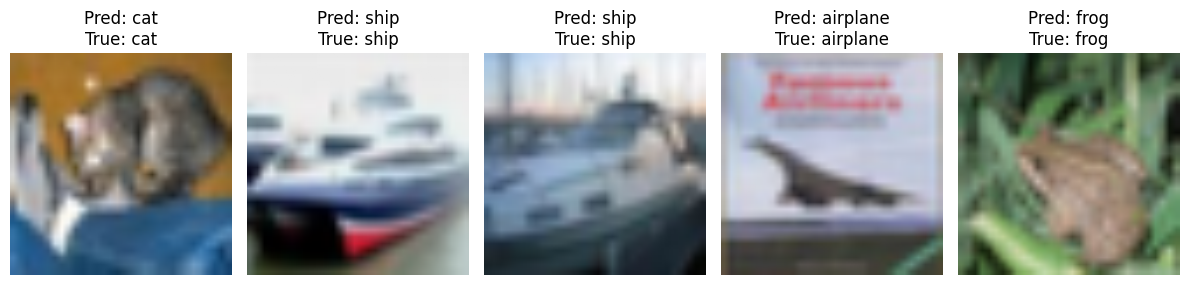


📈 Accuracy before pruning: 92.74%
📉 Accuracy after pruning + distillation: 93.21%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# ✅ Utility: Accuracy Evaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return acc

# ✅ Visualization: Predictions
def visualize_predictions(model, loader, class_names):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:5].to(device), labels[:5].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 3))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0)
        img = (img * 0.5) + 0.5  # unnormalize
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Loss for knowledge distillation
def distillation_loss(student_logits, teacher_logits, T, alpha):
    KD_loss = nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_logits/T, dim=1),
                                                  F.softmax(teacher_logits/T, dim=1)) * (T * T * alpha)
    CE_loss = F.cross_entropy(student_logits, teacher_logits.argmax(dim=1)) * (1. - alpha)
    return KD_loss + CE_loss

# ✅ Structured pruning (30%)
def structured_prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")
    return model

# ✅ Analyze sparsity
def analyze_sparsity(model):
    total_zeros, total_params = 0, 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            zeros = torch.sum(param == 0).item()
            total = param.numel()
            total_zeros += zeros
            total_params += total
            print(f"{name}: {100 * zeros / total:.2f}% sparsity")
    print(f"\n📊 Total sparsity: {100 * total_zeros / total_params:.2f}%")

# ✅ Parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ✅ Training functions
def train_model(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

def train_with_distillation(student_model, teacher_model, train_loader, optimizer, T=2.0, alpha=0.5, epochs=10):
    student_model.train()
    teacher_model.eval()
    for epoch in range(epochs):
        running_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            student_outputs = student_model(images)
            loss = distillation_loss(student_outputs, teacher_outputs, T, alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[KD] Epoch {epoch+1}, Loss: {running_loss:.4f}")

# ✅ Load student model (ResNet18)
def get_resnet():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

# ✅ TRAIN ORIGINAL STUDENT
student = get_resnet()
print("\n🎓 Training student model (before pruning)...")
optimizer = optim.Adam(student.parameters(), lr=0.001)
train_model(student, train_loader, optimizer, epochs=10)

print("\n✅ Evaluating unpruned student:")
orig_acc = evaluate(student, test_loader)
print(f"✅ Accuracy: {orig_acc:.2f}%")

# ✅ PARAM COUNT BEFORE PRUNING
orig_params = count_parameters(student)
print(f"\n📦 Parameters before pruning: {orig_params:,}")

# ✅ SAVE COPY OF ORIGINAL STUDENT FOR PRUNING
teacher_model = get_resnet()
teacher_model.load_state_dict(student.state_dict())  # clone student to teacher

# ✅ PRUNE STUDENT (30%)
print("\n✂️ Pruning student model (30% structured)...")
pruned_model = structured_prune_model(student, amount=0.3)

# ✅ DISTILLATION
print("\n🔥 Training student with knowledge distillation...")
optimizer = optim.Adam(pruned_model.parameters(), lr=0.0005)
train_with_distillation(pruned_model, teacher_model, train_loader, optimizer, T=2.0, alpha=0.7, epochs=10)

# ✅ FINAL EVALUATION
print("\n✅ Evaluating distilled + pruned student:")
pruned_acc = evaluate(pruned_model, test_loader)
print(f"✅ Accuracy: {pruned_acc:.2f}%")

# ✅ SPARSITY REPORT
print("\n📊 Sparsity after pruning:")
analyze_sparsity(pruned_model)

# ✅ PARAM COUNT AFTER PRUNING
pruned_params = count_parameters(pruned_model)
reduction = 100 * (orig_params - pruned_params) / orig_params
print(f"\n📦 Parameters after pruning: {pruned_params:,}")
print(f"📉 Parameter reduction: {orig_params - pruned_params:,} ({reduction:.2f}%)")

# ✅ SAVE THE MODEL
save_path = "./pruned_student_model.pth"
torch.save(pruned_model.state_dict(), save_path)
print(f"\n💾 Pruned model saved to: {save_path}")

# ✅ VISUALIZATION
print("\n🖼️ Visualizing Predictions on 5 Test Images:")
visualize_predictions(pruned_model, test_loader, train_set.classes)

# ✅ SUMMARY
print(f"\n📈 Accuracy before pruning: {orig_acc:.2f}%")
print(f"📉 Accuracy after pruning + distillation: {pruned_acc:.2f}%")
